# 007.001 Data Wrangling - Data Shape after Transformation

## Cohort Split

In [1]:
import pathlib
import sys
import pickle

from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(str(src_dir))
# import my class code from the source
# %aimport src-dir.filename
from data.data_process import transform_ts_to_supervised

from skoot.preprocessing import SelectiveMinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

PROJECT_DIR = pathlib.Path.cwd().resolve().parent
CONSOL_DATA_DIR = PROJECT_DIR / 'data' / '07-consolidated'

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
def rps_mean(estimator, X: np.ndarray, y: np.ndarray) -> float:
    """
    https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    Accepts:
    a scikit learn estimator model - estimator must have a predict_proba method
    X - data used to make prediction - validation data
    y = ground truth
    
    !!!!!!!!!!!
    """
    # Convert the y to a one hot encoded DataFrame in same sequence as prediction probas
    
    # Deal with situation where all classes not in y
    # Get the missing classes
    missing_classes = set(estimator.classes_) - set(y.unique())
    # Get ys as a DataFrame
    y_encoded = pd.get_dummies(y)
    if missing_classes:
        for missing_class in missing_classes:
            # Insert missing class into y encoded as 0
            y_encoded[missing_class] = 0
            
    # Put y matrix into the same column order as the probability predictions
    y_encoded = y_encoded[estimator.classes_]
        
    # Get the probabilities into a DataFrame
    pred_df = pd.DataFrame(estimator.predict_proba(X))
    
    # Cumulative Distributions
    pred_cdf = pd.DataFrame(pred_df).cumsum(axis='columns').values
    obs_cdf = y_encoded.cumsum(axis='columns').values
    # RPS Calculation and get sum
    # each prediction set could be a different length, so divide the sum by the number of pred observations
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').sum()/len(y)
    mean_RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').mean()
    # Negate return because for RPS lower is better, but for sklearn scorer higher is better
    return -mean_RPS

### Load & Review Data

In [4]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

In [5]:
df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,h_htGoals,h_yellowCards,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_htGoals,a_yellowCards,h_oddsWinMean,h_oddsDrawMean,a_oddsWinMean,oddsHwinBet,oddsDrawBet,oddsAwinBet,oddsHwinPinn,oddsDrawPinn,oddsAwinPinn,oddsHwinMax,oddsDrawMax,oddsAwinMax,result,h_result,a_result,h_goalsFor,h_goalsAgainst,a_goalsFor,a_goalsAgainst,h_impliedWinProbMean,h_impliedDrawProbMean,a_impliedDrawProbMean,a_impliedWinProbMean,a_oddsDrawMean,h_h_ftGoals-0,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-0,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-0,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTa

In [6]:
import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols1 = [col for col in df.columns if '-' in col]
    keeper_cols2 = [col for col in keeper_cols1 if int(col.split('-')[-1]) <= past_games]
    keeper_cols3 = [col for col in keeper_cols2 if int(col.split('-')[-1]) > 0]

    keeper_cols4 = keeper_cols3 + ['result']
    

    df = df[keeper_cols4]
    return keeper_cols3, df

PAST_GAMES = 30

keeper_cols3, df_cut = get_n_past_games(df, PAST_GAMES)

df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_a_shotsOnTarget-9,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,h_h_oddsWinMean-9,h_h_oddsWinMean-10,h_h_oddsWinMean-11,h_h_oddsWinMean-12,h_h_oddsWinMean-13,h_h_oddsWinMean-14,h_h_oddsWinMean-15,h_h_oddsWinMean-16,h_h_oddsWinMean-17,h_h_oddsWinMean-18,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_a_

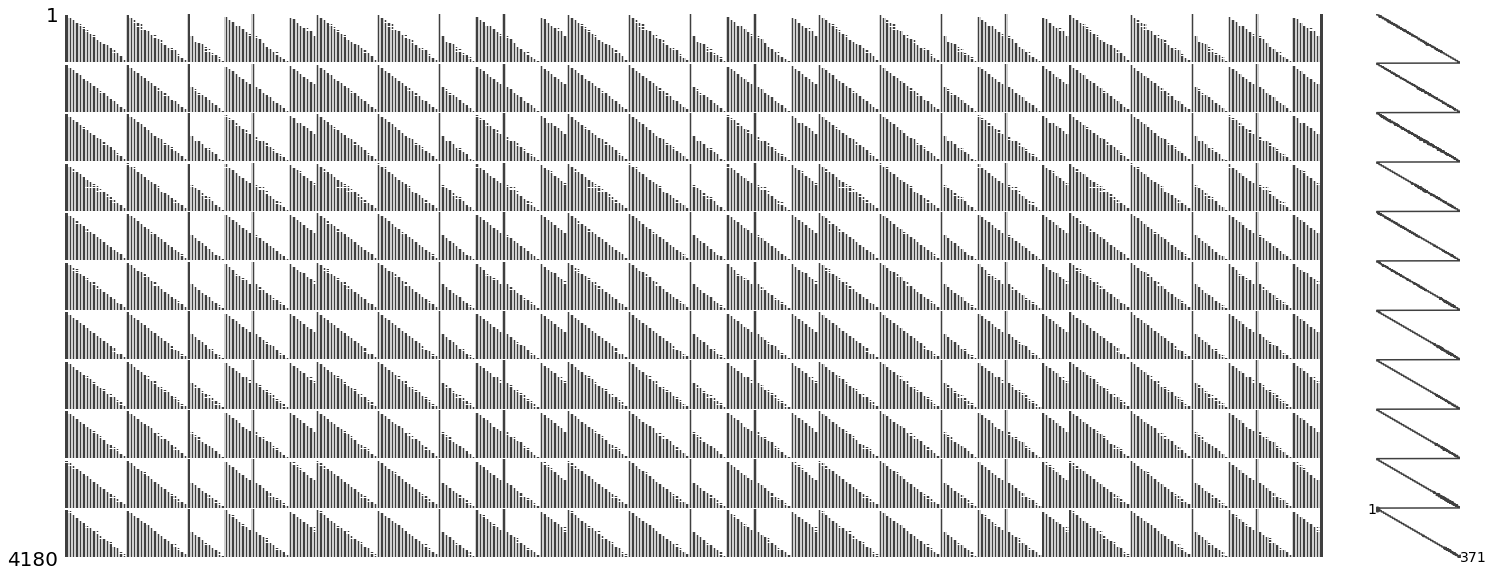

In [7]:
msno.matrix(df_cut)

plt.show();

### Cut Down to a Single Feature

In [8]:
h_h_ftGoals_cols = ['h_h_ftGoals-' + str(n) for n in range(1, 19)]
df_cut[h_h_ftGoals_cols].head(20)

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


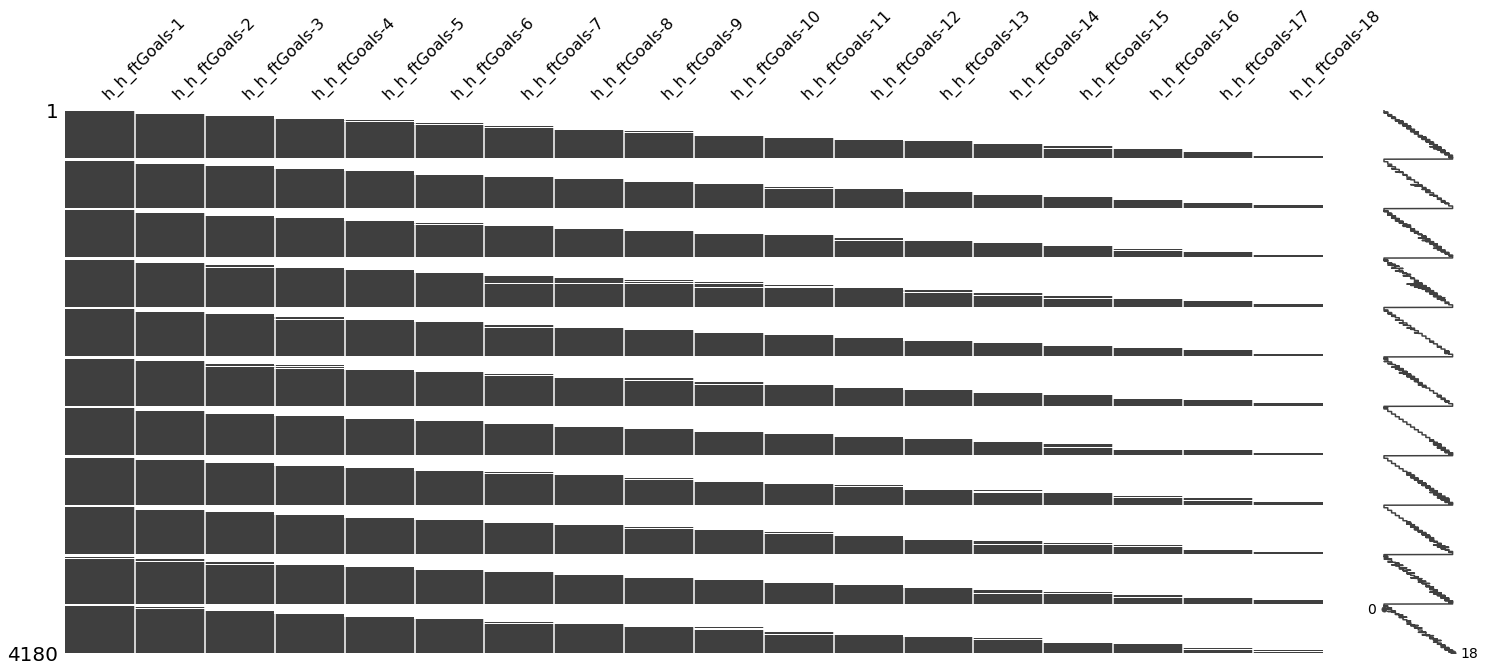

In [9]:
msno.matrix(df_cut[h_h_ftGoals_cols])
plt.show()

## Data Splitting Test Case

In [10]:
# Set up Test dataFrame
cutter_cols = ['h_h_feature-' + str(n) for n in range(1,9)]
other_cols = ['someFeature-' + str(n) for n in range(1,9)]
all_cutter_vals = []
for n, cutter_col in enumerate(cutter_cols):
    cutter_vals = [x for x in range(0,n)]
    cutter_vals = cutter_vals + [np.NaN] * (len(cutter_cols)-n)
    all_cutter_vals.append(cutter_vals)
#cutter_vals = []
df_test1 = pd.concat([pd.DataFrame(all_cutter_vals, columns=cutter_cols),
                     pd.DataFrame(all_cutter_vals, columns=other_cols)], axis=1)
df_test = pd.concat([df_test1, df_test1], axis=0)
df_test.set_index(np.arange(21, 21 + len(df_test)), inplace=True, drop=True)
df_test

,h_h_feature-1,h_h_feature-2,h_h_feature-3,h_h_feature-4,h_h_feature-5,h_h_feature-6,h_h_feature-7,h_h_feature-8,someFeature-1,someFeature-2,someFeature-3,someFeature-4,someFeature-5,someFeature-6,someFeature-7,someFeature-8
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
24,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
25,0.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,0.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN
26,0.0,1.0,2.0,3.0,4.0,NaN,NaN,NaN,0.0,1.0,2.0,3.0,4.0,NaN,NaN,NaN
27,0.0,1.0,2.0,3.0,4.0,5.0,NaN,NaN,0.0,1.0,2.0,3.0,4.0,5.0,NaN,NaN
28,0.0,1.0,2.0,3.0,4.0,5.0,6.0,NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Want to cut the rows at the following histories:
# - 2 game history - indices (21,22,23] and (29,30,31]- 22,23,30,31 
# - 3 to 4 history - indices [24,25] and [32,33] - 24,25,32,33
# - 5 to 6 history - indices [26, 27] and [34, 35] - 26,27,34,35
# - 7 history - indices[28] and [36] - 28,36

In [12]:
def get_data_splits(full_df, len_season=380, game_splits=[2,4,6], split_based_on='h_h_ftGoals'):
    
    cutter_cols_unsorted = [col for col in full_df.columns if split_based_on in col]
    max_cutter_n = max([int(col.split('-')[-1]) for col in cutter_cols_unsorted])
    cutter_cols = [split_based_on + '-' + str(n) for n in range(1,max_cutter_n+1)]
    cutter_df = full_df[cutter_cols]
    game_coverage = game_splits[0] - 0
    game_ranges = [(n-game_coverage+1, n) for n in game_splits]

    nan_ranges =[(max_cutter_n -n1, max_cutter_n-n2) for n1, n2 in game_ranges]

    index_splitters = []
    for nan_range in nan_ranges:
        crit1 = cutter_df.isnull().sum(axis=1) <= nan_range[0]
        crit2 = cutter_df.isnull().sum(axis=1) >= nan_range[1]
        temp_df = cutter_df[crit1 & crit2].copy()
        index_splitters.append(temp_df.index)

    return index_splitters

In [13]:
index_splitters = get_data_splits(df_test, len_season=8, game_splits=[2,4,6,8], split_based_on='h_h_feature')
data_packs = [df_test.loc[index_splitter,:].dropna(axis=1, how='all') for index_splitter in index_splitters]

data_packs[0]

,h_h_feature-1,h_h_feature-2,someFeature-1,someFeature-2
22,0.0,NaN,0.0,NaN
23,0.0,1.0,0.0,1.0
30,0.0,NaN,0.0,NaN
31,0.0,1.0,0.0,1.0


In [14]:
data_packs[1]

,h_h_feature-1,h_h_feature-2,h_h_feature-3,h_h_feature-4,someFeature-1,someFeature-2,someFeature-3,someFeature-4
24,0.0,1.0,2.0,NaN,0.0,1.0,2.0,NaN
25,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
32,0.0,1.0,2.0,NaN,0.0,1.0,2.0,NaN
33,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0


In [15]:
data_packs[2]

,h_h_feature-1,h_h_feature-2,h_h_feature-3,h_h_feature-4,h_h_feature-5,h_h_feature-6,someFeature-1,someFeature-2,someFeature-3,someFeature-4,someFeature-5,someFeature-6
26,0.0,1.0,2.0,3.0,4.0,NaN,0.0,1.0,2.0,3.0,4.0,NaN
27,0.0,1.0,2.0,3.0,4.0,5.0,0.0,1.0,2.0,3.0,4.0,5.0
34,0.0,1.0,2.0,3.0,4.0,NaN,0.0,1.0,2.0,3.0,4.0,NaN
35,0.0,1.0,2.0,3.0,4.0,5.0,0.0,1.0,2.0,3.0,4.0,5.0


In [16]:
data_packs[3]

,h_h_feature-1,h_h_feature-2,h_h_feature-3,h_h_feature-4,h_h_feature-5,h_h_feature-6,h_h_feature-7,someFeature-1,someFeature-2,someFeature-3,someFeature-4,someFeature-5,someFeature-6,someFeature-7
28,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0
36,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0


## Try on Full Season data

In [17]:
game_splits = [5,9,15,18]
len_season=380
split_based_on = 'h_h_ftGoals'
index_splitters = get_data_splits(df_cut, len_season=len_season,
                                  game_splits=game_splits, split_based_on=split_based_on)
data_packs = [df_cut.loc[index_splitter,:].dropna(axis=1, how='all') for index_splitter in index_splitters]



In [18]:
data_packs[0].head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
17,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.57,NaN,NaN,NaN,NaN,3.04,NaN,NaN,NaN,NaN,NaN,NaN,2.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.51,NaN,NaN,NaN,NaN,3.22,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin
18,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.17,NaN,NaN,NaN,NaN,4.34,NaN,NaN,NaN,NaN,NaN,NaN,1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN,NaN,NaN,NaN,3.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin
19,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82,NaN,NaN,NaN,NaN,5.42,NaN,NaN,NaN,NaN,NaN,NaN,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN,NaN,3.50,NaN,NaN,NaN,NaN,NaN,NaN,

In [19]:
data_packs[3].head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_a_shotsOnTarget-9,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,h_h_oddsWinMean-9,h_h_oddsWinMean-10,h_h_oddsWinMean-11,h_h_oddsWinMean-12,h_h_oddsWinMean-13,h_h_oddsWinMean-14,h_h_oddsWinMean-15,h_h_oddsWinMean-16,h_h_oddsWinMean-17,h_h_oddsWinMean-18,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_a_

In [20]:
print(data_packs[0].shape)
print(data_packs[1].shape)
print(data_packs[2].shape)
print(data_packs[3].shape)

(1100, 141)
(1100, 226)
(1100, 341)
(1100, 371)


### Model on Season Period Splits

In [21]:
data_packs[0].head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
17,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.57,NaN,NaN,NaN,NaN,3.04,NaN,NaN,NaN,NaN,NaN,NaN,2.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.51,NaN,NaN,NaN,NaN,3.22,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin
18,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.17,NaN,NaN,NaN,NaN,4.34,NaN,NaN,NaN,NaN,NaN,NaN,1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN,NaN,NaN,NaN,3.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin
19,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82,NaN,NaN,NaN,NaN,5.42,NaN,NaN,NaN,NaN,NaN,NaN,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN,NaN,3.50,NaN,NaN,NaN,NaN,NaN,NaN,

In [22]:
# We will impute row wise on each match
filled_data_packs = []
for data_pack in data_packs:
    filled_data_packs.append(data_pack.fillna(method='ffill', axis=1))
filled_data_packs[0].head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,7,7,7,7,7,14,14,14,14,14,14,14,13,13,13,13,13,13,13,13,12,12,12,12,12,12,12,12,6,6,6,6,6,7,7,7,7,7,7,7,9,9,9,9,9,9,9,9,6,6,6,6,6,6,6,6,5.57,5.57,5.57,5.57,5.57,3.04,3.04,3.04,3.04,3.04,3.04,3.04,2.41,2.41,2.41,2.41,2.41,2.41,2.41,2.41,2.38,2.38,2.38,2.38,2.38,2.38,2.38,2.38,3.51,3.51,3.51,3.51,3.51,3.22,3.22,3.22,3.22,3.22,3.22,3.22,3.18,3.18,3.18,3.18,3.18,3.18,3.18,3.18,3.19,3.19,3.19,3.19,3.19,3.19,3.19,3.19,hwin
18,1,1,1,1,1,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,15,15,15,15,15,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,3,3,3,3,3,3,3,3,11,11,11,11,11,10,10,10,10,10,10,10,8,8,8,8,8,8,8,8,2,2,2,2,2,2,2,2,6.17,6.17,6.17,6.17,6.17,4.34,4.34,4.34,4.34,4.34,4.34,4.34,1.66,1.66,1.66,1.66,1.66,1.66,1.66,1.66,12.24,12.24,12.24,12.24,12.24,12.24,12.24,12.24,3.61,3.61,3.61,3.61,3.61,3.3,3.3,3.3,3.3,3.3,3.3,3.3,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,5.26,5.26,5.26,5.26,5.26,5.26,5.26,5.26,hwin
19,1,1,1,1,1,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,14,14,14,14,14,5,5,5,5,5,5,5,12,12,12,12,12,12,12,12,6,6,6,6,6,6,6,6,8,8,8,8,8,3,3,3,3,3,3,3,5,5,5,5,5,5,5,5,3,3,3,3,3,3,3,3,1.82,1.82,1.82,1.82,1.82,5.42,5.42,5.42,5.42,5.42,5.42,5.42,2.85,2.85,2.85,2.85,2.85,2.85,2.85,2.85,2.18,2.18,2.18,2.18,2.18,2.18,2.18,2.18,3.3,3.3,3.3,3.3,3.3,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.19,3.19,3.19,3.19,3.19,3.19,3.19,3.19,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,hwin
20,1,1,1,1,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14,14,14,14,14,7,7,7,7,7,7,7,9,9,9,9,9,9,9,9,14,14,14,14,14,14,14,14,5,5,5,5,5,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2.33,2.33,2.33,2.33,2.33,2.86,2.86,2.86,2.86,2.86,2.86,2.86

There is a problem with this imputation
Take row 21 where the away team has not played any away games - The row wise imputation drags the h_h column across here

Maybe if any row where a feature -1 column is Nan, this row should be dropped - There is nothing to impute for these features.

I think this is only a problem on the first few games, after that all features had been primed - ie have at least one value to impute along the rest of the feature

In [23]:
for n, data_pack in enumerate(filled_data_packs):
    print(f'Up to {game_splits[n]} Games')
    X = data_pack.copy(deep=True)
    y = X.pop('result')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    skf = StratifiedKFold(n_splits=5)

    scaler = SelectiveMinMaxScaler()
    xgb = XGBClassifier()

    pipe = Pipeline([('scaler', scaler),
                    ('xgb', xgb)])

    scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=rps_mean)

    print(f'Scores: {scores}')
    print(f'Mean_Score {np.mean(scores)}\n')

Up to 5 Games
Scores: [-0.21935259 -0.2016985  -0.23079408 -0.19747865 -0.22408343]
Mean_Score -0.21468145040176784

Up to 9 Games
Scores: [-0.20194937 -0.21225164 -0.22784196 -0.21216333 -0.20751396]
Mean_Score -0.2123440527052379

Up to 15 Games
Scores: [-0.16927399 -0.19837583 -0.18579114 -0.22966771 -0.22583949]
Mean_Score -0.20178963228529484

Up to 18 Games
Scores: [-0.19650893 -0.21705509 -0.21353891 -0.20263591 -0.19065664]
Mean_Score -0.20407909562914145

